# Background

In section 4.3 of [Fine-Tuning Pretrained Language Models: Weight Initializations, Data Orders, and Early Stopping](https://arxiv.org/abs/2002.06305) the author poses an interesting question:

> A natural question that follows is whether some random seeds are good across datasets. While the data order is dataset specific, the same weight initialization can be applied to multiple classifiers trained with different datasets

An anecdote is given...

> We find that some initializations perform con-sistently well. For instance, WI seed 12 has the best perfor-mance on CoLA and RTE, the second best on MRPC, and third best on SST. This suggests that, perhaps surprisingly, some weight initializations perform well across tasks.

...and then the question is posed as future work:

> We defer this question to future work, and release the results of our 2,100 fine-tuning experiments to facilitate further study of this question by the community.

# Analysis

### Goal
Determine (with more statistical rigor) whether or not some weight initializations (WI) are better than others across multiple tasks.

### Speculative Motivation
Suppose there exists an "ideal" WI which out performs all other WIs when fine tuning on any* downstream task. This ideal WI should be found and published for popular pretrained models. This would result in a higher mean and lower variance for the model's fine tuning performance.

**note: the tasks analyzed here are all binary classification. An "ideal" WI would have to be found for each type of downstream task (classification, seq2seq, span, etc.) which changes the model's final layers.*

# Findings

It is difficult to compare weight initializations accros tasks because the task scores follow different non-normal distributions.

Performing a [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) and breaking some of the methodology (inter-task ranking instead of global ranking) appears to confirm the author's anecdote about seed 12.


## Data Prep

In [1]:
import pickle
from collections import namedtuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scikit_posthocs

In [2]:
!wget www.cs.cmu.edu/~jessed/data_hosting/random_seed_data.zip

--2020-04-09 17:44:28--  http://www.cs.cmu.edu/~jessed/data_hosting/random_seed_data.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24299538 (23M) [application/zip]
Saving to: ‘random_seed_data.zip’

random_seed_data.zi 100%[===================>]  23.17M   598KB/s    in 29s     

2020-04-09 17:44:57 (827 KB/s) - ‘random_seed_data.zip’ saved [24299538/24299538]



In [3]:
!unzip random_seed_data.zip

Archive:  random_seed_data.zip
  inflating: all_data                
  inflating: description.txt         


In [4]:
with open("all_data", "rb") as f:
    data = pickle.load(f)
    
tm = namedtuple("task_metric", ["task", "metric"])
task_metrics = [tm("mrpc", "acc_and_f1"), tm("sst", "acc"), tm("cola", "mcc"), tm("rte", "acc")]

# extract the best evaluation score from each trining run 
for tm in task_metrics:
    # weight initialization (wi)
    for wi in data[tm.task].keys():
        # data order (do)
        for do in data[tm.task][wi].keys():
            evaluations = data[tm.task][wi][do][tm.metric]["during"]
            data[tm.task][wi][do][tm.metric]["best"] = max(evaluation[1] for evaluation in evaluations)

## Data for analysis

Since we want to compare weight initializations across tasks, the different data orderings can be viewed as independent fine tunings of the model.  This gives us a sample for each WI on which to do statistical analysis.

Due to the computational constraints in the paper (see section 2.2), seeds 1-15 have a sample size of `n = 90 = 25 + 25 + 25 + 15` and seeds 16-25 have a sample size of `n = 75 = 25 + 25 + 25`.  Additionally, seeds 1-15 cannot be fairly compared to seeds 16-25 without dropping the scores from the SST task. As a result:
* when comparing accros all tasks, seeds 16-25 will not be included
* when comparing accros all seeds, the SST task will not be included

seed 13: n = 90
seed 23: n = 75


,wi,task,score
0,19,mrpc,0.894556
1,19,mrpc,0.903558
2,19,mrpc,0.894556
3,19,mrpc,0.889594
4,19,mrpc,0.760784


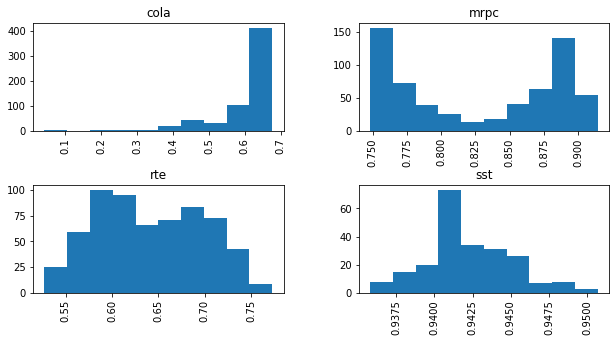

In [6]:
# creat a dataframe containing the weight initialization, task, and score for each fine tuning run
l = []
for tm in task_metrics:
    for wi in data[tm.task].keys():
        for do in data[tm.task][wi].keys():
            l.append([wi, tm.task, data[tm.task][wi][do][tm.metric]["best"]])
        
df = pd.DataFrame(l, columns=["wi", "task", "score"])
print("seed 13: n =", len(df[df.wi == 13]))
print("seed 23: n =", len(df[df.wi == 23]))

plt.rcParams['figure.figsize'] = [10, 5]
ax = df.drop("wi", axis=1).hist(by="task")

df.head()

## Null and Void Methodology 

Since the distribution of the tasks' scores follow different non-normal distributions, adjusting/normalizing the scores is not straight forward.  This is the main challenge in this analysis and likely why the author did not perform it.

Here I perform a [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) to compare the performance of WIs.  The assumption of "*identically shaped and scaled distribution for all groups, except for any difference in medians*" is not perfect (see cell below), but acceptable for me.  **The ranks used are inter-task ranks, not global ranks. This deviation in methodology which makes the results null and void.** That said, Kruskal-Wallis is built to handle ties, maybe it could be considered a workaround. 

In [7]:
#kernal density estimation to do a rough check of Kruskal-Wallis assumption
#for wi in range(1,26):
#    df[df.wi == wi].drop("wi", axis=1).plot.density()

## Comparison of all seeds

In [8]:
all_seeds = df[df.task != "sst"]
all_seeds["rank"] = all_seeds.groupby("task")["score"].rank(ascending=False)

ranks = [all_seeds[all_seeds.wi == x]["rank"].tolist() for x in range(1, all_seeds.wi.nunique() + 1)]
stats.kruskal(*ranks)

/home/jpostel1/envs/base/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


KruskalResult(statistic=76.61847004291539, pvalue=2.0839239866532965e-07)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f17696404a8>,
 <matplotlib.colorbar.ColorbarBase at 0x7f1769536ef0>)

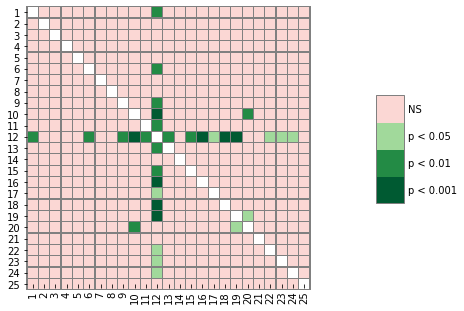

In [9]:
# small p-value, so continue on to post hoc analysis
plt.rcParams['figure.figsize'] = [10, 5]
heatmap_args = {'linewidths': 0.25, 
                'linecolor': '0.5', 
                'clip_on': False, 
                'square': True, 
                'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

pvalues = scikit_posthocs.posthoc_dunn(ranks, val_col="rank", group_col="wi", p_adjust="bonferroni")
scikit_posthocs.sign_plot(pvalues, **heatmap_args)

#use your favorie posthoc:
#they look roughly the same except for nemenyi (lower power test)
#scikit_posthocs.posthoc_nemenyi
#scikit_posthocs.posthoc_conover
#scikit_posthocs.posthoc_vanwaerden

## Comparison of all tasks

In [10]:
df = df[df.wi <= 15]
df["rank"] = df.groupby("task")["score"].rank("max", ascending=False)
ranks = [df[df.wi == x]["rank"].tolist() for x in range(1, df.wi.nunique() + 1)]
stats.kruskal(*ranks)

KruskalResult(statistic=40.577978149444974, pvalue=0.00020719698047887256)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1769625d30>,
 <matplotlib.colorbar.ColorbarBase at 0x7f1765871e10>)

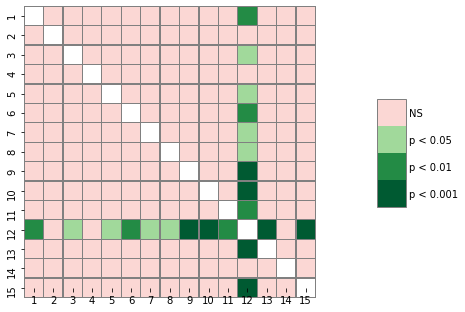

In [11]:
# small p-value, so continue on to post hoc analysis
pvalues = scikit_posthocs.posthoc_vanwaerden(ranks, val_col="rank", group_col="wi", p_adjust="bonferroni")
scikit_posthocs.sign_plot(pvalues, **heatmap_args)

#use your favorie posthoc:
#they look roughly the same except for nemenyi (lower power test)
#scikit_posthocs.posthoc_nemenyi
#scikit_posthocs.posthoc_conover
#scikit_posthocs.posthoc_vanwaerden